In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import os
import subprocess
import gc
import pandas as pd
print("uproot version", uproot.__version__)
print("awkward version", ak.__version__)
print("numpy version", np.__version__)
print("matplotlib version", matplotlib.__version__)
print("hist version", hist.__version__)
print("vector version", vector.__version__)
#print("os version", os.__version__)
#print("subprocess version", subprocess.__version__)
#print("gc version", gc.__version__)
print("pandas version", pd.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1
pandas version 1.5.3


In [2]:
vector.register_awkward() 

In [3]:
SAMPLE_RUNS = [290323, 290327, 290848, 291361, 291360, 291362, 290853, 290860, 291373, 290374, 290375, 291399,
               291400, 290894, 290895, 290404, 291943, 291944, 291948, 291953, 290932, 290423, 291447, 290935, 
               290425, 290427, 291451, 291453, 291976, 291982, 290456, 290458, 290459, 291482, 291485, 290975, 
               290980, 290469, 292012, 291002, 291003, 291004, 291005, 290501, 292040, 292060, 292061, 292062, 
               291041, 290539, 290540, 292075, 292077, 292080, 290549, 290553, 291590, 292106, 292108, 292109, 
               292115, 290590, 291618, 291622, 291624, 292140, 290612, 292160, 292162, 292163, 292164, 292166, 
               290632, 291657, 292168, 292192, 290658, 290660, 291690, 291692, 291694, 291698, 291706, 290687, 
               290692, 290696, 290699, 292242, 292265, 291755, 292269, 292270, 291760, 292273, 292274, 290742, 
               291769, 291263, 290764, 290766, 291283, 291284, 291285, 291795, 291796, 290776, 291803, 290787]
print(len(SAMPLE_RUNS))

108


In [4]:
def integral(histo: hist.Hist, start: float, stop: float):
    start_bin = histo.axes[0].index(start)  
    stop_bin = histo.axes[0].index(stop)
    return histo[start_bin:stop_bin].sum()

def getTracksGen(events):
    return ak.zip({
        "px":events["Muon_GenPx"],
        "py":events["Muon_GenPy"],
        "pz":events["Muon_GenPz"],
        "E":events["Muon_GenE"],
        "label":events["Muon_GenLabel"],
        "code":events["Muon_GenMotherPDGCode"]
    }, with_name='Momentum4D')


def scan(dataDescription, 
              hMagGen:hist.Hist, hPhiGen:hist.Hist, hEtaGen:hist.Hist, hPtGen:hist.Hist, hMassGen:hist.Hist, hMass2Gen:hist.Hist,
              eventSelectorGen = lambda x:[True]*len(x), trackSelectorGen = lambda x:[True]*len(x),
              verbose:bool = False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
        print(dir(vector.backends.awkward.MomentumArray4D))
    """
    
    Entries = 0
    goodEntries = 0
    PDG = []
    
    for batch in uproot.iterate(dataDescription,
                                ["Muon_GenE", "Muon_GenPx", "Muon_GenPy", "Muon_GenPz", "Muon_GenLabel", "Muon_GenMotherPDGCode"],                                
                                report = True):

        events = batch[0] # batch[1] is the report info

        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break

        goodEvents = events[eventSelectorGen(events)] 
        tracks = getTracksGen(goodEvents)
        goodTracks = tracks[trackSelectorGen(tracks)]
        #goodTracks.show()

        hMagGen.fill(ak.flatten(goodTracks.p))
        hPhiGen.fill(ak.flatten(goodTracks.phi))
        hPtGen.fill(ak.flatten(goodTracks.pt))
        hEtaGen.fill(ak.flatten(goodTracks.eta))
        hMassGen.fill(ak.flatten(goodTracks.mass))

        pairs = ak.combinations(goodTracks, 2)

        Px = pairs["0"].px + pairs["1"].px
        Py = pairs["0"].py + pairs["1"].py
        Pz = pairs["0"].pz + pairs["1"].pz
        E = pairs["0"].E + pairs["1"].E

        pairs2 = ak.zip({"px":Px, "py":Py, "pz":Pz, "E":E}, with_name = 'Momentum4D')

        hMass2Gen.fill(ak.flatten(pairs2.mass))
        
        Entries += len(events)
        goodEntries += len(ak.flatten(goodTracks))/2
        PDG = np.union1d(PDG, ak.flatten(goodTracks.code))


        if verbose:
            print("-----------------------------------------------------------")
            print(batch[1], "\nEntries: ", Entries, "\nJ/Psi: ", int(goodEntries), "\nPDG: ", PDG)
        gc.collect()
        
    return Entries, goodEntries, PDG

In [5]:
%%time

hMag = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhi = hist.Hist(hist.axis.Regular(bins = 200, start = -22/7, stop = 22/7, name = '$\phi$'))
hEta = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hPt = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$p_T$'))
hMass = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m$'))

hMass2 = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{q \overline{q}}$'))

Entries = goodEntries = 0
PDG = []

for run in SAMPLE_RUNS:
    a, b, c = scan(dataDescription = f"/pbs/throng/training/nantes-m2-rps-exp/data/run{run}.mc.root:genTree",
                   hMagGen = hMag, hPhiGen = hPhi, hEtaGen = hEta, hPtGen = hPt, hMassGen = hMass, hMass2Gen = hMass2,
                   eventSelectorGen = lambda x: x["Muon_GenMotherPDGCode"] == 443, #trackSelectorGen = lambda x: ((x.pt > 2) & (x.pt < 3)),
                   verbose = True)
    
    Entries += a
    goodEntries += b
    PDG = np.union1d(PDG, c)
    
print("-----------------------------------------------------------", "\nEntries: ", Entries, "\nJ/Psi: ", int(goodEntries), "\nPDG: ", PDG)

-----------------------------------------------------------
<Report start=0 stop=70000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290323.mc.root:/genTree;1'> 
Entries:  70000 
J/Psi:  46507 
PDG:  [443]
-----------------------------------------------------------
<Report start=0 stop=6000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290327.mc.root:/genTree;1'> 
Entries:  6000 
J/Psi:  4020 
PDG:  [443]
-----------------------------------------------------------
<Report start=0 stop=90000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290848.mc.root:/genTree;1'> 
Entries:  90000 
J/Psi:  60139 
PDG:  [443]
-----------------------------------------------------------
<Report start=0 stop=20000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run291361.mc.root:/genTree;1'> 
Entries:  20000 
J/Psi:  13281 
PDG:  [443]
-----------------------------------------------------------
<Report start=0 stop=90000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run2

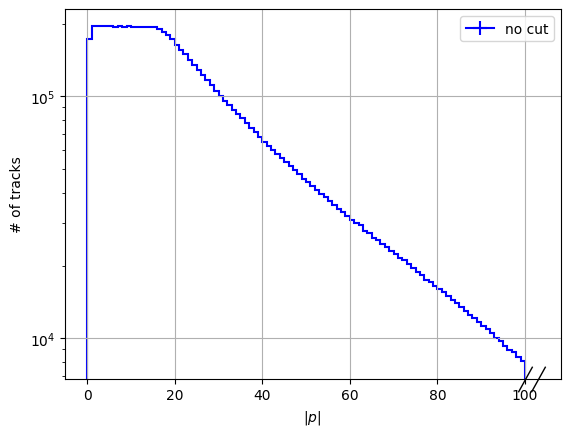

In [6]:
hMag.plot(color = "blue", label = "no cut")
#hMag_cut.plot(color = "red", label = "cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

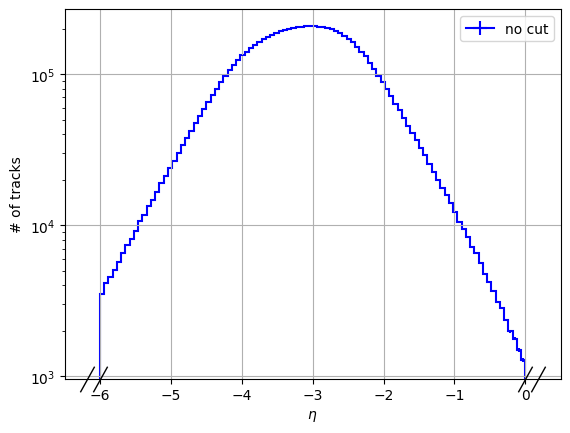

In [7]:
hEta.plot(color = "blue", label = "no cut")
#hEta_cut.plot(color = "red", label = "cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

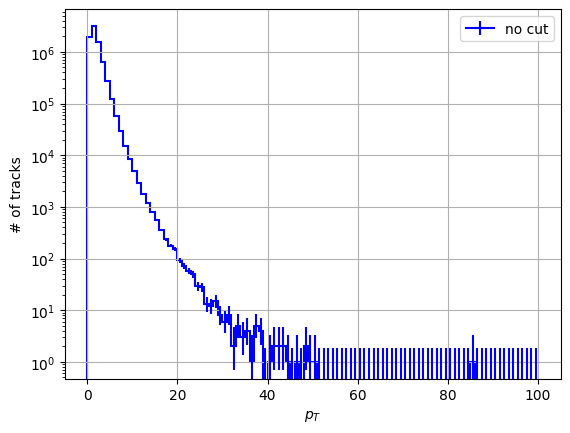

In [8]:
hPt.plot(color = "blue", label = "no cut")
#hPt_cut.plot(color = "red", label = "cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

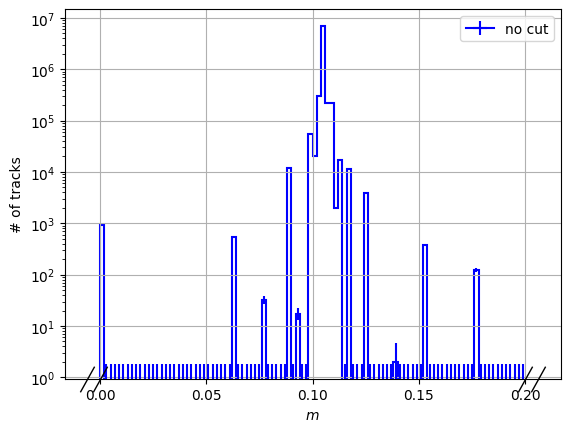

In [9]:
hMass.plot(color = "blue", label = "no cut")
#hMass_cut.plot(color = "red", label = "cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

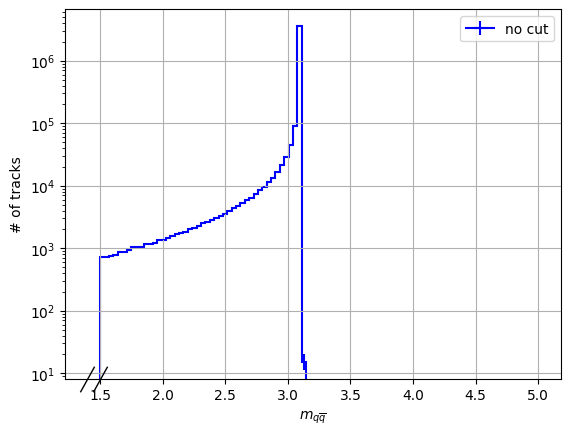

In [10]:
hMass2.plot(color = "blue", label = "no cut")
#hMass2.plot(color = "red", label = "cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()